In [1]:
import time
start_time = time.time()
import os
HOME = os.environ['HOME']
# os.chdir(f'{HOME}/desktop/LTT1445_fits_files/Test/Tes2/Tes3/Tes4')
os.chdir(f'{HOME}/desktop/LTT1445_fits_files/Test/Tes2/Tes3')                    #2nd epoch
# os.chdir(f'{HOME}/desktop/LTT1445_fits_files/Test/Tes2')                         #1st epoch

In [34]:
import joblib
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import mad_std, sigma_clip
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import warnings
warnings.filterwarnings("ignore")

import exoplanet as xo

from arctor3 import Arctor, info_message

In [3]:
transit1 = [0,512,300,513]
transit2 = [0,512,178,220]
transit3 = [0,512,150,180]

In [4]:
def instantiate_arctor(planet_name, transit, data_dir, working_dir, file_type):
    planet = Arctor(
        planet_name=planet_name,
        data_dir=data_dir,
        working_dir=working_dir,
        file_type=file_type)

    joblib_filename = f'{planet_name}_savedict.joblib.save'
    joblib_filename = f'{working_dir}/{joblib_filename}'
    if os.path.exists(joblib_filename):
        info_message('Loading Data from Save File')
        planet.load_data(joblib_filename)
    else:
        info_message('Loading New Data Object')
        planet.load_data(transit)

    return planet

def create_raw_lc_stddev(planet):
    ppm = 1e6
    phot_vals = planet.photometry_df
    lc_std_rev = phot_vals.iloc[planet.idx_rev].std(axis=0)                
    lc_std_fwd = phot_vals.iloc[planet.idx_fwd].std(axis=0)                

    lc_med_rev = np.median(phot_vals.iloc[planet.idx_rev], axis=0)
    lc_med_fwd = np.median(phot_vals.iloc[planet.idx_rev], axis=0)

    lc_std = np.mean([lc_std_rev, lc_std_fwd], axis=0)
    lc_med = np.mean([lc_med_rev, lc_med_fwd], axis=0)

    return lc_std / lc_med * ppm

In [5]:
plot_verbose = False
save_now = False
planet_name = 'PlanetName'
file_type = 'flt.fits'

HOME = os.environ['HOME']
# base_dir = os.path.join(HOME, 'path', 'to', 'base')
# data_dir = os.path.join(base_dir, 'path', 'to', 'data')
# data_dir = os.path.join(data_dir, 'HST', 'FLTs')
# working_dir = os.path.join(base_dir, 'path', 'to', 'savefiles')
base_dir = os.path.join(HOME, 'desktop', 'LTT1445_fits_files', 'Test', 'Tes2', 'Tes3')        #2nd epoch
# base_dir = os.path.join(HOME, 'desktop', 'LTT1445_fits_files', 'Test', 'Tes2')                #1st epoch
data_dir = os.path.join(base_dir)
data_dir = os.path.join(data_dir)
working_dir = os.path.join(base_dir)

In [6]:
transit = transit1
planet = instantiate_arctor(planet_name, transit, data_dir, working_dir, file_type)
print(planet)

[INFO] Initializing Instance of the `Arctor` Object
[INFO] Loading New Data Object
[INFO] Loading Fits Files


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 170.22it/s]


[INFO] Creating New Flux/Error/Time Attributes


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 67.83it/s]


[INFO] Found 94 flt.fits files


In [7]:
planet.clean_cosmic_rays()
planet.calibration_trace_location()
planet.identify_trace_direction()
planet.simple_phots()
planet.center_all_traces()
planet.fit_trace_slopes()
planet.compute_sky_background(subpixels=32)
planet.compute_columnwise_sky_background()

[INFO] Flagging Cosmic Rays using `Temporal Simple` Technique


100%|█████████████████████████████████████████████████████████████████████████████████| 213/213 [00:10<00:00, 19.76it/s]


[INFO] Cosmic Ray Mask Creation Took 10.78724193572998 seconds
None
[INFO] Calibration the Median Trace Location
[INFO] Cubic Spline Interpolating the Median Trace Location
[INFO] Calibration the Per Image Trace Location


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 990.08it/s]


[INFO] Identifying Trace Direction per Image


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 609.44it/s]


[INFO] Computing the Center of the Trace


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:56<00:00,  1.68it/s]


[INFO] Fitting a slope to the Center of the Trace


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 143.61it/s]


In [8]:
# Set up the list of aperture widths and heights to search
min_aper_width = 1
max_aper_width = 100
min_aper_height = 1
max_aper_height = 100

aper_widths = np.arange(min_aper_width, max_aper_width + 2, 5)
aper_heights = np.arange(min_aper_height, max_aper_height + 2, 5)

In [9]:
planet.do_multi_phot(aper_widths, aper_heights)
print("code took", (time.time()-start_time)/60, "minutes")

[INFO] Beginning Multi-Aperture Photometry
[INFO] Creating Apertures


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 113.91it/s]


[INFO] Configuing Photoutils.Aperture_Photometry
[INFO] Computing Aperture Photometry per Image
[INFO] Aperture Photometry per Image took 318.36377811431885 seconds for 41454 apertures.
[INFO] Restructuring Aperture Photometry into DataFrames
    aperture_sum_1x1  aperture_sum_6x1  aperture_sum_11x1  aperture_sum_16x1  \
0       6.296293e+06      6.412166e+06       6.531044e+06       6.648012e+06   
1       6.519370e+06      6.620606e+06       6.724885e+06       6.830137e+06   
2       6.235962e+06      6.348219e+06       6.459498e+06       6.571002e+06   
3       6.491890e+06      6.610596e+06       6.712846e+06       6.812125e+06   
4       6.211405e+06      6.326723e+06       6.442572e+06       6.558612e+06   
..               ...               ...                ...                ...   
89      6.060079e+06      6.267385e+06       6.477939e+06       6.676975e+06   
90      5.900198e+06      6.002888e+06       6.108343e+06       6.218816e+06   
91      6.130891e+06      6.316016e+0

In [10]:
planet_coarse_photometry_df = planet.photometry_df.copy()
planet.photometry_df


,aperture_sum_1x1,aperture_sum_6x1,aperture_sum_11x1,aperture_sum_16x1,aperture_sum_21x1,aperture_sum_26x1,aperture_sum_31x1,aperture_sum_36x1,aperture_sum_41x1,aperture_sum_46x1,...,aperture_sum_56x101,aperture_sum_61x101,aperture_sum_66x101,aperture_sum_71x101,aperture_sum_76x101,aperture_sum_81x101,aperture_sum_86x101,aperture_sum_91x101,aperture_sum_96x101,aperture_sum_101x101
0,6.296293e+06,6.412166e+06,6.531044e+06,6.648012e+06,6.761876e+06,6.873628e+06,6.989301e+06,7.108222e+06,7.226034e+06,7.341491e+06,...,2.507942e+07,2.545530e+07,2.582742e+07,2.619630e+07,2.656297e+07,2.692918e+07,2.729278e+07,2.765415e+07,2.801532e+07,2.837569e+07
1,6.519370e+06,6.620606e+06,6.724885e+06,6.830137e+06,6.928936e+06,7.024472e+06,7.121818e+06,7.220858e+06,7.315722e+06,7.403779e+06,...,2.558581e+07,2.595803e+07,2.633200e+07,2.669982e+07,2.706028e+07,2.741865e+07,2.778973e+07,2.816648e+07,2.853756e+07,2.889498e+07
2,6.235962e+06,6.348219e+06,6.459498e+06,6.571002e+06,6.683796e+06,6.799305e+06,6.913215e+06,7.024716e+06,7.136830e+06,7.250162e+06,...,2.541058e+07,2.577744e+07,2.613966e+07,2.650448e+07,2.687610e+07,2.724670e+07,2.760909e+07,2.796632e+07,2.832214e+07,2.868706e+07
3,6.491890e+06,6.610596e+06,6.712846e+06,6.812125e+06,6.909087e+06,7.007833e+06,7.107341e+06,7.202127e+06,7.292074e+06,7.380707e+06,...,2.565973e+07,2.603627e+07,2.640670e+07,2.676725e+07,2.712699e+07,2.749295e+07,2.786653e+07,2.823938e+07,2.860346e+07,2.895996e+07
4,6.211405e+06,6.326723e+06,6.442572e+06,6.558612e+06,6.673851e+06,6.788167e+06,6.902938e+06,7.017241e+06,7.131318e+06,7.245435e+06,...,2.512739e+07,2.549819e+07,2.587223e+07,2.624455e+07,2.661062e+07,2.697324e+07,2.733809e+07,2.770757e+07,2.807387e+07,2.843527e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,6.060079e+06,6.267385e+06,6.477939e+06,6.676975e+06,6.857418e+06,7.035170e+06,7.227872e+06,7.431097e+06,7.595069e+06,7.670956e+06,...,2.839817e+07,2.875316e+07,2.913435e+07,2.952395e+07,2.988680e+07,3.022019e+07,3.052757e+07,3.070181e+07,3.074097e+07,3.074366e+07
90,5.900198e+06,6.002888e+06,6.108343e+06,6.218816e+06,6.329807e+06,6.436357e+06,6.540319e+06,6.644101e+06,6.751098e+06,6.862759e+06,...,2.515560e+07,2.551441e+07,2.587769e+07,2.625126e+07,2.662741e+07,2.699694e+07,2.736235e+07,2.772402e+07,2.808400e+07,2.844710e+07
91,6.130891e+06,6.316016e+06,6.411481e+06,6.501086e+06,6.591264e+06,6.686569e+06,6.782923e+06,6.872281e+06,6.951769e+06,7.027680e+06,...,2.585137e+07,2.624060e+07,2.661694e+07,2.697221e+07,2.732307e+07,2.768694e+07,2.806615e+07,2.843983e+07,2.879162e+07,2.913300e+07
92,5.860645e+06,5.962037e+06,6.062443e+06,6.167810e+06,6.279025e+06,6.388279e+06,6.492663e+06,6.594919e+06,6.697476e+06,6.805219e+06,...,2.527612e+07,2.563637e+07,2.598734e+07,2.634742e+07,2.672672e+07,2.711381e+07,2.748240e+07,2.783197e+07,2.817751e+07,2.853792e+07


In [11]:
coarse_snr_lightcurves = create_raw_lc_stddev(planet)
coarse_min_snr = coarse_snr_lightcurves[coarse_snr_lightcurves.argmin()]
coarse_min_snr_colname = planet.photometry_df.columns[coarse_snr_lightcurves.argmin()]
coarse_min_snr_col = planet.normed_photometry_df[coarse_min_snr_colname]
coarse_temp = coarse_min_snr_colname.split('_')[-1].split('x')
coarse_min_snr_aper_width, coarse_min_snr_aper_height = np.int32(coarse_temp)

In [12]:
info_message(f'Coarse Aperture Photometry Resulted in {coarse_min_snr:0.0f}ppm with '
             f'{coarse_min_snr_aper_width}x{coarse_min_snr_aper_height} aperture size')

[INFO] Coarse Aperture Photometry Resulted in 3459ppm with 1x101 aperture size


In [13]:
fine_buffer = 10
fine_aper_widths = np.arange(coarse_min_snr_aper_width - fine_buffer,
                             coarse_min_snr_aper_width + fine_buffer)

fine_aper_heights = np.arange(coarse_min_snr_aper_height - fine_buffer,
                              coarse_min_snr_aper_height + fine_buffer)

In [14]:
planet.do_multi_phot(fine_aper_widths, fine_aper_heights)

[INFO] Beginning Multi-Aperture Photometry
[INFO] Creating Apertures


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 132.61it/s]


[INFO] Configuing Photoutils.Aperture_Photometry
[INFO] Computing Aperture Photometry per Image
[INFO] Aperture Photometry per Image took 403.40391063690186 seconds for 37600 apertures.
[INFO] Restructuring Aperture Photometry into DataFrames
    aperture_sum_-9x91  aperture_sum_-8x91  aperture_sum_-7x91  \
0         2.002855e+07        2.017455e+07        2.032110e+07   
1         2.005953e+07        2.020862e+07        2.035732e+07   
2         2.002708e+07        2.017313e+07        2.031992e+07   
3         2.004157e+07        2.018620e+07        2.033150e+07   
4         2.002725e+07        2.017342e+07        2.031958e+07   
..                 ...                 ...                 ...   
89        2.003307e+07        2.017636e+07        2.031914e+07   
90        2.003499e+07        2.018781e+07        2.034053e+07   
91        2.002764e+07        2.017243e+07        2.031720e+07   
92        2.003383e+07        2.018604e+07        2.033729e+07   
93        2.000255e+07        2

[INFO] Adding column aperture_sum_-3x96 to self.photometry_df
[INFO] Adding column aperture_sum_-2x96 to self.photometry_df
[INFO] Adding column aperture_sum_-1x96 to self.photometry_df
[INFO] Adding column aperture_sum_0x96 to self.photometry_df
[INFO] Adding column aperture_sum_2x96 to self.photometry_df
[INFO] Adding column aperture_sum_3x96 to self.photometry_df
[INFO] Adding column aperture_sum_4x96 to self.photometry_df
[INFO] Adding column aperture_sum_5x96 to self.photometry_df
[INFO] Adding column aperture_sum_7x96 to self.photometry_df
[INFO] Adding column aperture_sum_8x96 to self.photometry_df
[INFO] Adding column aperture_sum_9x96 to self.photometry_df
[INFO] Adding column aperture_sum_10x96 to self.photometry_df
[INFO] Adding column aperture_sum_-9x97 to self.photometry_df
[INFO] Adding column aperture_sum_-8x97 to self.photometry_df
[INFO] Adding column aperture_sum_-7x97 to self.photometry_df
[INFO] Adding column aperture_sum_-6x97 to self.photometry_df
[INFO] Adding co

[INFO] Adding column aperture_sum_5x103 to self.photometry_df
[INFO] Adding column aperture_sum_6x103 to self.photometry_df
[INFO] Adding column aperture_sum_7x103 to self.photometry_df
[INFO] Adding column aperture_sum_8x103 to self.photometry_df
[INFO] Adding column aperture_sum_9x103 to self.photometry_df
[INFO] Adding column aperture_sum_10x103 to self.photometry_df
[INFO] Adding column aperture_sum_-9x104 to self.photometry_df
[INFO] Adding column aperture_sum_-8x104 to self.photometry_df
[INFO] Adding column aperture_sum_-7x104 to self.photometry_df
[INFO] Adding column aperture_sum_-6x104 to self.photometry_df
[INFO] Adding column aperture_sum_-5x104 to self.photometry_df
[INFO] Adding column aperture_sum_-4x104 to self.photometry_df
[INFO] Adding column aperture_sum_-3x104 to self.photometry_df
[INFO] Adding column aperture_sum_-2x104 to self.photometry_df
[INFO] Adding column aperture_sum_-1x104 to self.photometry_df
[INFO] Adding column aperture_sum_0x104 to self.photometry_d

[INFO] Adding column aperture_sum_0x110 to self.photometry_df
[INFO] Adding column aperture_sum_1x110 to self.photometry_df
[INFO] Adding column aperture_sum_2x110 to self.photometry_df
[INFO] Adding column aperture_sum_3x110 to self.photometry_df
[INFO] Adding column aperture_sum_4x110 to self.photometry_df
[INFO] Adding column aperture_sum_5x110 to self.photometry_df
[INFO] Adding column aperture_sum_6x110 to self.photometry_df
[INFO] Adding column aperture_sum_7x110 to self.photometry_df
[INFO] Adding column aperture_sum_8x110 to self.photometry_df
[INFO] Adding column aperture_sum_9x110 to self.photometry_df
[INFO] Adding column aperture_sum_10x110 to self.photometry_df


In [15]:
planet_fine_photometry_df = planet.photometry_df.copy()

In [16]:
fine_snr_lightcurves = create_raw_lc_stddev(planet)
fine_min_snr = fine_snr_lightcurves[fine_snr_lightcurves.argmin()]
fine_min_snr_colname = planet.photometry_df.columns[fine_snr_lightcurves.argmin()]
fine_min_snr_flux = planet.normed_photometry_df[fine_min_snr_colname]
fine_min_snr_uncs = planet.normed_uncertainty_df[fine_min_snr_colname]
fine_temp = fine_min_snr_colname.split('_')[-1].split('x')
fine_min_snr_aper_width, fine_min_snr_aper_height = np.int32(fine_temp)

In [17]:
info_message(f'Fine Aperture Photometry Resulted in {fine_min_snr:0.0f}ppm with '
             f'{fine_min_snr_aper_width}x{fine_min_snr_aper_height} aperture size; '
             f'with median uncertainties of {np.median(fine_min_snr_uncs)*1e6:0.0f} ppm')

[INFO] Fine Aperture Photometry Resulted in 588ppm with -8x110 aperture size; with median uncertainties of 223 ppm


In [18]:
data_df = pd.DataFrame()
data_df['flux'] = fine_min_snr_flux.values
data_df['unc'] = fine_min_snr_uncs.values
data_df['times'] = planet.times
idx_fwd = planet.idx_fwd
idx_rev = planet.idx_rev
# data_df.sort_values('times', inplace=True)
# data_df = data_df.reset_index()
# data_df.drop(['index'], axis=1, inplace=True)
data_df

,flux,unc,times
0,0.999817,0.000222,59486.596360
1,1.001791,0.000223,59486.597239
2,0.999742,0.000222,59486.598119
3,1.000605,0.000223,59486.598998
4,0.999763,0.000222,59486.599878
...,...,...,...
89,1.000305,0.000223,59486.750144
90,1.000501,0.000223,59486.751024
91,1.000000,0.000223,59486.751903
92,1.000425,0.000223,59486.752783


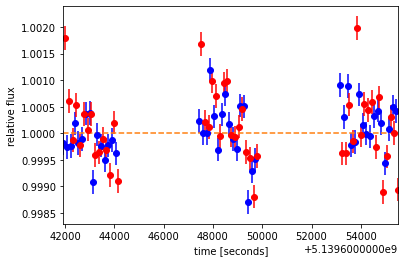

In [19]:
# Compute a limb-darkened light curve using starry
t = data_df['times']
u = []
flux = data_df['flux']
yerr = data_df['unc']
# Note: the `eval` is needed because this is using Theano in
# the background

plt.errorbar(t[idx_fwd], flux[idx_fwd], yerr[idx_fwd], fmt='o', color="b")
plt.errorbar(t[idx_rev], flux[idx_rev], yerr[idx_rev], fmt='o', color="r")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

In [20]:
fluxppm = (data_df['flux'] - 1)*1e6

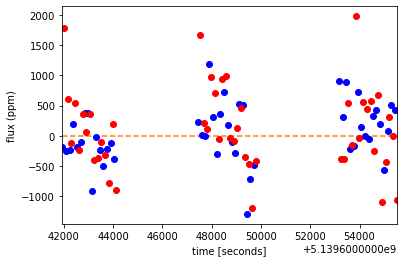

In [21]:
plt.errorbar(t[idx_fwd], fluxppm[idx_fwd], yerr[idx_fwd], fmt='o', color="b")
plt.errorbar(t[idx_rev], fluxppm[idx_rev], yerr[idx_rev], fmt='o', color="r")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("flux (ppm)")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

In [22]:
print("code took", (time.time()-start_time)/60, "minutes")

code took 14.229592816034954 minutes


In [24]:
print(t.min())

5139641925.461664


In [46]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  9 11:49:59 2020

@author: Trevor
"""
import numpy as np
import matplotlib.pyplot as plt
import pickle
from skyfield.api import load
from astropy.time import Time
from barycorrpy import utc_tdb

###########   Working Directory   #####################   


def mjd_bjd(MJD_UTC, flux, flux_err, raDeg, decDeg):
    #fpath='/Users/Trevor/Pythoncode/HST/WASP79/W79_data/'
    fpath = base_dir
#     fileObject = open(fpath+'wlc_extract_out', 'rb')
#     print(fileObject)
#     MJD_UTC, flux, flux_err, raDeg, decDeg, scidata_0, scidata, xybox = pickle.load(fileObject)
#     fileObject.close()
    
    stations_url = 'http://celestrak.com/NORAD/elements/science.txt'
    satellites = load.tle_file(stations_url)
    by_name = {sat.name: sat for sat in satellites}
    satellite = by_name['HST']
    print(satellite)
    
    # MJDUTC in correct format for datetime64
    MJDUTC_dt = Time(MJD_UTC, format='mjd', scale='utc')
    yrs =[]
    mths = []
    days = []
    hours = []
    mins = []
    secs = []
    
    for i in np.arange(len(MJDUTC_dt)):
        tt = MJDUTC_dt[i].datetime64
        yrss = tt.astype('datetime64[Y]')
        MM = tt.astype('datetime64[M]')
        mthss = MM-yrss
        dd = tt.astype('datetime64[D]')
        dayss = dd-MM
        hh = tt.astype('datetime64[h]')
        hourss = hh-dd
        mm = tt.astype('datetime64[m]')
        minss = mm-hh
        ss = tt.astype('datetime64[ns]')
        secss = ss-mm
    
        yrs.append(yrss.astype(int)+1970)
        mths.append(mthss.astype(int)+1)
        days.append(dayss.astype(int)+1)
        hours.append(hourss.astype(int))
        mins.append(minss.astype(int))
        secs.append(secss.astype('float')*1e-9)
    
    ts = load.timescale(builtin=True)
    
    tmin = ts.utc(yrs,mths,days,hours,mins,secs) 
    geocentric = satellite.at(tmin)
    subpoint = geocentric.subpoint()
    lati = subpoint.latitude.degrees
    longit = subpoint.longitude.degrees
    elevation = subpoint.elevation.m
    
    for i in np.arange(len(elevation)):
        elevation[i] = int(elevation[i])
        
    JDUTC = MJD_UTC + 2400000.5
    results=[]
    for i in np.arange(len(JDUTC)):
        results.append(utc_tdb.JDUTC_to_BJDTDB(JDUTC[i], ra= raDeg, dec = decDeg, 
                                               lat=lati[i], longi=longit[i], 
                                               alt=elevation[i]))
        if i % 12 == 0:
                print(i)
    
    BJD_TDB=[]
    for i in np.arange(len(results)):
        BJD_TDB.append(float(results[i][0]))
    BJD_TDB = np.array(BJD_TDB)
    
    plt.figure()
    plt.errorbar(BJD_TDB, flux, flux_err, fmt='o', color='k')
    plt.xlabel('Time ($BJD_{TDB}$)')
    plt.ylabel('Flux (e$^-$)')
    plt.show()

#     outpath = fpath                                                                                #Commented this out
#     fileObject = open(outpath+'BJD_TDB', 'wb')
#     pickle.dump([BJD_TDB, flux, flux_err], fileObject)
#     fileObject.close()    
    
    return BJD_TDB

HST catalog #20580 epoch 2022-05-11 12:12:42 UTC
0
12
24
36


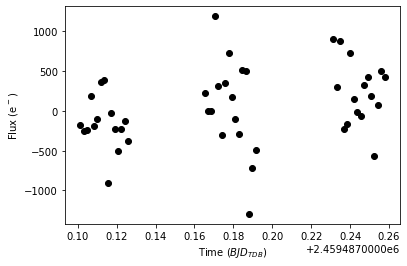

HST catalog #20580 epoch 2022-05-11 12:12:42 UTC
0
12
24
36


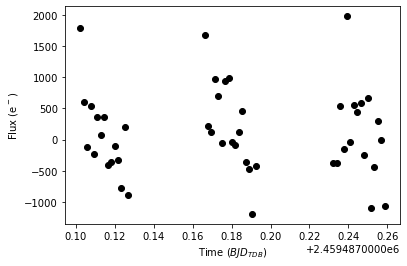

In [95]:
# tbjd = data_df['times']
# tbjd[idx_fwd]
t = data_df['times']
u = []
flux = data_df['flux']
yerr = data_df['unc']

hdul = fits.open(get_pkg_data_filename(glob.glob(base_dir+'/*fits')[1]))
raDeg = hdul[0].header['RA_TARG']
decDeg = hdul[0].header['DEC_TARG']
# timefwd_bjd = mjd_bjd(tbjd[idx_fwd], flux[idx_fwd], yerr[idx_fwd], raDeg, decDeg)
timefwd_bjd = mjd_bjd(t[idx_fwd].reset_index(drop=True), fluxppm[idx_fwd].reset_index(drop=True), yerr[idx_fwd].reset_index(drop=True), raDeg, decDeg)
timerev_bjd = mjd_bjd(t[idx_rev].reset_index(drop=True), fluxppm[idx_rev].reset_index(drop=True), yerr[idx_rev].reset_index(drop=True), raDeg, decDeg)

In [96]:
# t[idx_fwd].reset_index(drop=True)

Text(0.5, 0, 'time [days]')

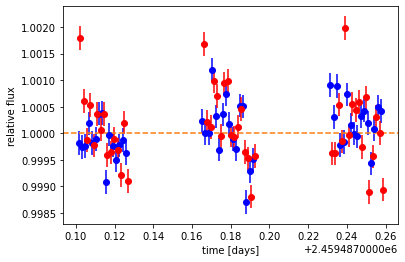

In [98]:
plt.errorbar(timefwd_bjd, flux[idx_fwd], yerr[idx_fwd], fmt='o', color="b")
plt.errorbar(timerev_bjd, flux[idx_rev], yerr[idx_rev], fmt='o', color="r")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
# plt.xlim(t.min(), t.max());

In [105]:
if timefwd_bjd.max() < timerev_bjd.max():
    print('rev')

rev


In [110]:
Tcon = 2458412.58159
Period = 3.1239035
Con = 0
for i in range(400):
    if Tcon + Period*i > timefwd_bjd.min():
        if Tcon + Period*i < timerev_bjd.max():
            Con = Tcon + Period*i
            print(Con)

2459487.204394


Text(0.5, 0, 'time [days]')

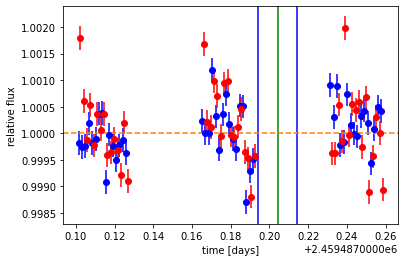

In [112]:
Transit = 0.0201
plt.axvline(Con, color = 'g', label = 'axvline - full height') #Middle of transit
plt.axvline(Con+Transit/2, color = 'b', label = 'axvline - full height')
plt.axvline(Con-Transit/2, color = 'b', label = 'axvline - full height')
plt.errorbar(timefwd_bjd, flux[idx_fwd], yerr[idx_fwd], fmt='o', color="b")
plt.errorbar(timerev_bjd, flux[idx_rev], yerr[idx_rev], fmt='o', color="r")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("relative flux")
plt.xlabel("time [days]")